In [23]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [24]:
import re

from os import walk
from os.path import join

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imshow, show

# Read classes from file
labels = np.genfromtxt('../classes.csv', delimiter=',', dtype=str)
# because of space after comma we read redundant empty column
labels = np.array([l[0] for l in labels])

data_path = "../database/"
files = list()
for (dirpath, dirnames, filenames) in walk(data_path):
    files = filenames  
    
data_images = list()
data_labels = list()
label_from_name = r"([a-zA-z]+)[-_]\d+.pgm"

# here we load all the images and find their label from filename
for f in files:
    match = re.match(label_from_name, f)
    if match:
        label = match.groups()[0]
        if label in labels:
            data_labels.append(label)
            data_images.append(imread(join(data_path, f), as_grey=True))      
    else: 
        # if name does not match our regexp or label is not in the list
        # of classes - not read from database
        continue 

In [25]:
"""Set of utils for input image processing."""
import math

import numpy as np

from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.morphology import medial_axis
from skimage.measure import label

from scipy import interpolate

# Dictionary of increments of current pixel coordinates
# for finding a neighborhood with given connectivity
CONNECTIVITY_INC = {
    4: {
        0: (0, -1),
        1: (-1, 0),
        2: (0, 1),
        3: (1, 0)
    },
    8: {
        0: (0, -1),
        1: (-1, -1),
        2: (-1, 0),
        3: (-1, 1),
        4: (0, 1),
        5: (1, 1),
        6: (1, 0),
        7: (1, -1),
    }
}


def pad_image(im, color="b"):
    """Pad the image by one pixel."""
    if color == "b":
        padded_im = np.array(
            [np.concatenate([[0], row, [0]]) for row in im], dtype=np.uint8)
        new_row = np.zeros((1, padded_im.shape[1]), dtype=np.uint8)
        padded_im = np.concatenate([new_row, padded_im, new_row])
    else:
        raise ValueError("Padding is not implemented for thes color")
    return padded_im


def trace_border(im, connectivity=4):
    """Trace border with Moore-Neighbor Tracing."""
    border = list()
    # we pad image by one pixel from all sides
    # padding ensures us not to go out of domain
    padded_im = pad_image(im)

    background_pixel = padded_im[0][0]
    current_pixel = padded_im[0][0]
    start = None

    # find starting pixel
    for i in range(padded_im.shape[0]):
        for j in range(padded_im.shape[1]):
            if padded_im[i][j] != current_pixel:
                start = (i, j)
                border.append((i, j))
                break
        else:
            continue
            # executed if the loop ended normally (no break)
        break

    # iterations of the algo
    current_pixel = start
    direction = 0
    while (True):
        if connectivity == 8:
            i = (direction + 2) % 8
            while i != (direction + 7) % 8:
                next_pixel = (
                    current_pixel[0] + CONNECTIVITY_INC[connectivity][i][0],
                    current_pixel[1] + CONNECTIVITY_INC[connectivity][i][1])
                if padded_im[next_pixel] != background_pixel:
                    current_pixel = next_pixel
                    border.append(current_pixel)
                    direction = (i + 4) % 8
                    break
                i = (i + 1) % 8
        elif connectivity == 4:
            i = (direction + 1) % 4
            while i != (direction + 4) % 8:
                next_pixel = (
                    current_pixel[0] + CONNECTIVITY_INC[connectivity][i][0],
                    current_pixel[1] + CONNECTIVITY_INC[connectivity][i][1])
                if padded_im[next_pixel] != background_pixel:
                    current_pixel = next_pixel
                    border.append(current_pixel)
                    direction = (i + 2) % 4
                    break
                i = (i + 1) % 4
        else:
            raise ValueError("Invalid connectivity specified")
    # stop condition
        if current_pixel == border[0]:
            break
    # remove padding from image (it will influence border coordinates)
    border = [(pixel[0] - 1, pixel[1] - 1) for pixel in border]
    return border


def fill_border(im, border, point, color=255):
    """Fill the border."""
    image = np.array(im)
    next_points = [point]

    temporary_color = 120

    while len(next_points) > 0:
        point = next_points.pop()
        image[point] = temporary_color

        top = (point[0] - 1, point[1])
        down = (point[0] + 1, point[1])
        left = (point[0], point[1] - 1)
        right = (point[0], point[1] + 1)

        if image[top] != temporary_color and top not in border:
            next_points.append(top)
        if image[down] != temporary_color and down not in border:
            next_points.append(down)
        if image[left] != temporary_color and left not in border:
            next_points.append(left)
        if image[right] != temporary_color and right not in border:
            next_points.append(right)
    image[image == temporary_color] = color
    return image


def fill_foreground(image):
    """."""
    img_labels = label(image)
    label_count = np.bincount(img_labels.ravel())
    background = np.argmax(label_count)
    filled_image = image
    filled_image[img_labels != background] = 255
    return filled_image


def sample_border_points(border, size):
    """Sample points from the border uniformly."""
    sample_indices = np.sort(np.random.choice(range(len(border)), size=size))
    sampled_border = [p for i, p in enumerate(border) if i in sample_indices]
    return sampled_border


def smooth_border(im, disk_size=5):
    """Smooth the border with median filter."""
    new_im = np.array(im)
    new_im = median(new_im, disk(disk_size))
    return new_im


def medial_axis_skeleton(im):
    """Find skeleton and the distances of points on skeleton to the border."""
    skel, distance = medial_axis(im, return_distance=True)
    dist_on_skel = distance * skel
    return dist_on_skel



In [26]:
def preprocess_image(image):
    """."""
    im = pad_image(image)
    filled_image = fill_foreground(im)
    smoothed_image = smooth_border(filled_image)
    return smoothed_image

def preprocess_image_without_smooth(image):
    """."""
    im = pad_image(image)
    filled_image = fill_foreground(im)
    return filled_image

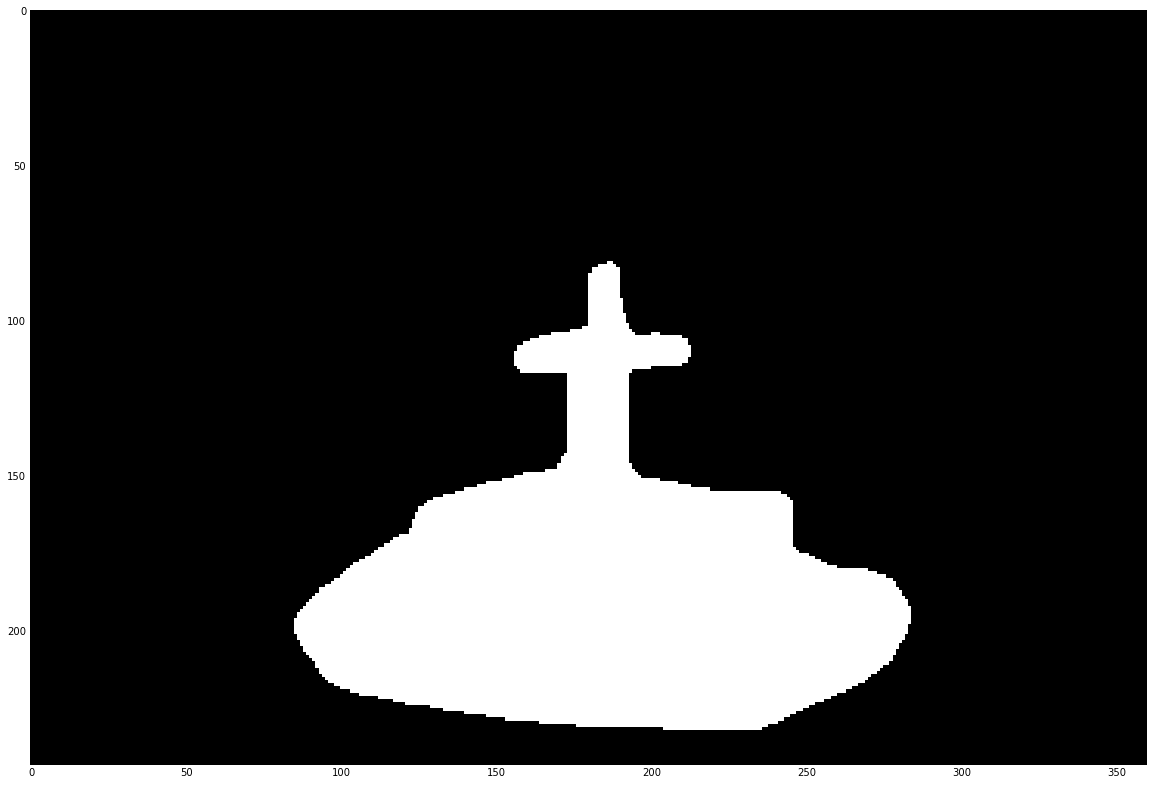

In [27]:
imshow(data_images[2])

In [28]:
car = data_images[2]
car_smooth = preprocess_image(car)

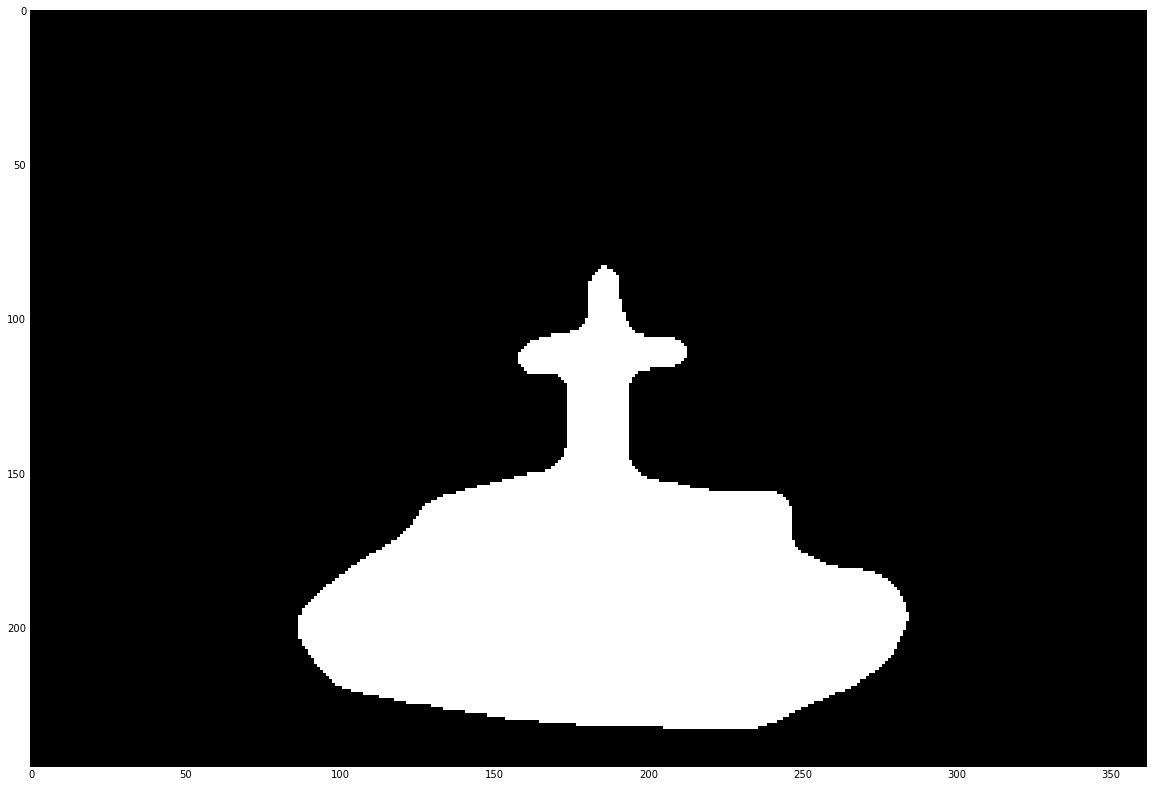

In [29]:
imshow(car_smooth)

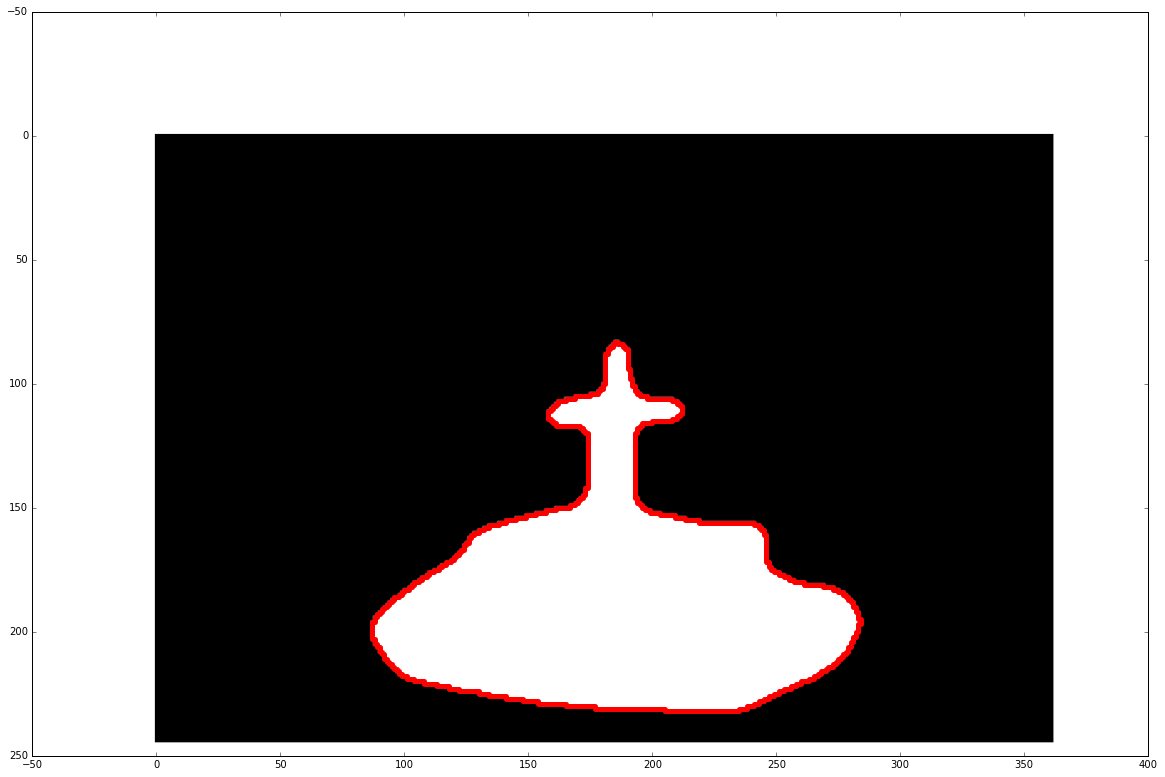

In [30]:
car_border = trace_border(car_smooth)

width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(car_smooth, cmap=plt.cm.gray)
ax.plot([b[1] for b in car_border], [b[0] for b in car_border], color="r", linewidth=5)

In [31]:
from scipy.interpolate import UnivariateSpline

def curvature_splines(x, y=None, error=0.1):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std))
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std))

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 3 / 2)
    return curvature

In [32]:
x_car = np.array([x for (x,y) in car_border])
y_car = np.array([y for (x,y) in car_border])

In [33]:
car_curvature = curvature_splines(x_car, y_car)

In [34]:
car_curvature

array([ -1.32362582e-01,  -1.65920851e-01,  -1.95615138e-01,
        -2.13147372e-01,  -2.12947648e-01,  -1.96025023e-01,
        -1.68771127e-01,  -1.38426981e-01,  -1.09901880e-01,
        -8.53562059e-02,  -6.51347735e-02,  -4.87326498e-02,
        -3.53841561e-02,  -2.43329300e-02,  -1.49228602e-02,
        -6.60798955e-03,   1.06768486e-03,   8.49818836e-03,
         1.60428579e-02,   2.40500933e-02,   3.28760777e-02,
         4.28957873e-02,   5.45001808e-02,   6.80674319e-02,
         8.38876466e-02,   1.01250725e-01,   1.18520337e-01,
         1.33915317e-01,   1.45180152e-01,   1.50226696e-01,
         1.47966823e-01,   1.38824795e-01,   1.24542645e-01,
         1.07427639e-01,   8.95645246e-02,   7.23808703e-02,
         5.65948873e-02,   4.25995586e-02,   3.03763950e-02,
         1.94702927e-02,   9.33988716e-03,  -6.22055137e-04,
        -1.11196165e-02,  -2.30291377e-02,  -3.75226494e-02,
        -5.62440014e-02,  -8.15090958e-02,  -1.16352624e-01,
        -1.63773942e-01,

In [35]:
from sklearn.preprocessing import normalize

norm_car_curv = normalize(car_curvature, norm='max')

/home/johnpaul/anaconda/envs/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [36]:
norm_car_curv

array([[ -4.81203331e-01,  -6.03204207e-01,  -7.11157598e-01,
         -7.74895924e-01,  -7.74169830e-01,  -7.12647734e-01,
         -6.13566367e-01,  -5.03250417e-01,  -3.99547590e-01,
         -3.10311948e-01,  -2.36797058e-01,  -1.77167241e-01,
         -1.28638876e-01,  -8.84622136e-02,  -5.42519641e-02,
         -2.40233043e-02,   3.88156157e-03,   3.08951101e-02,
          5.83237086e-02,   8.74339625e-02,   1.19520773e-01,
          1.55947364e-01,   1.98135064e-01,   2.47458719e-01,
          3.04973010e-01,   3.68096373e-01,   4.30879938e-01,
          4.86848289e-01,   5.27801526e-01,   5.46148205e-01,
          5.37932450e-01,   5.04696665e-01,   4.52773999e-01,
          3.90552502e-01,   3.25611264e-01,   2.63140197e-01,
          2.05750356e-01,   1.54870426e-01,   1.10433192e-01,
          7.07841262e-02,   3.39551008e-02,  -2.26147753e-03,
         -4.04252957e-02,  -8.37222847e-02,  -1.36413355e-01,
         -2.04474712e-01,  -2.96325803e-01,  -4.22999229e-01,
        

In [37]:
pos_car_curv = []
for x in norm_car_curv[0]:
    if x>=0:
        pos_car_curv.append(x)
    elif x<-1:
        pos_car_curv.append(1)
    else:
        pos_car_curv.append(-x)

In [38]:
pos_car_curv

[0.48120333068992399,
 0.60320420684245402,
 0.7111575982440983,
 0.7748959242110055,
 0.77416982980408933,
 0.7126477340224836,
 0.61356636653314511,
 0.50325041668174764,
 0.39954758975238475,
 0.310311948048894,
 0.23679705797866213,
 0.17716724097621925,
 0.12863887639563751,
 0.08846221355172873,
 0.054251964069555639,
 0.024023304313907371,
 0.0038815615745756453,
 0.03089511014457582,
 0.058323708586923588,
 0.087433962455963313,
 0.1195207730122838,
 0.1559473640951424,
 0.19813506351158441,
 0.24745871921017343,
 0.3049730100093393,
 0.3680963730100385,
 0.43087993799830071,
 0.48684828880719605,
 0.52780152593949103,
 0.54614820487000892,
 0.5379324497066249,
 0.50469666540960612,
 0.45277399867595958,
 0.39055250212195358,
 0.32561126408231122,
 0.2631401971610795,
 0.20575035561914856,
 0.15487042637871271,
 0.11043319224650087,
 0.070784126233153374,
 0.033955100831623827,
 0.0022614775264917912,
 0.040425295717673074,
 0.083722284659901183,
 0.13641335520386458,
 0.204474

In [39]:
colors = [(curv, 0.1, 0.1) for curv in pos_car_curv]

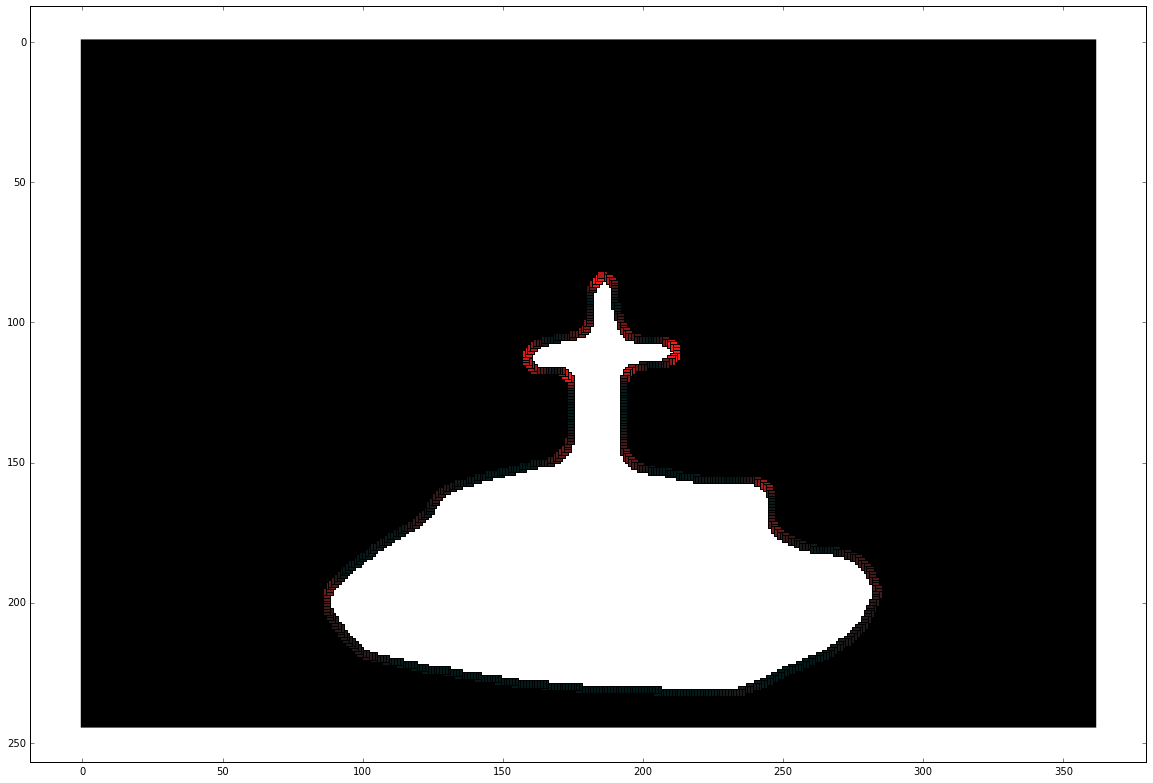

In [40]:
width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(car_smooth, cmap=plt.cm.gray)

ax.scatter([b[1] for b in car_border], [b[0] for b in car_border], c=colors, s=50, marker=',')

/home/johnpaul/anaconda/envs/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


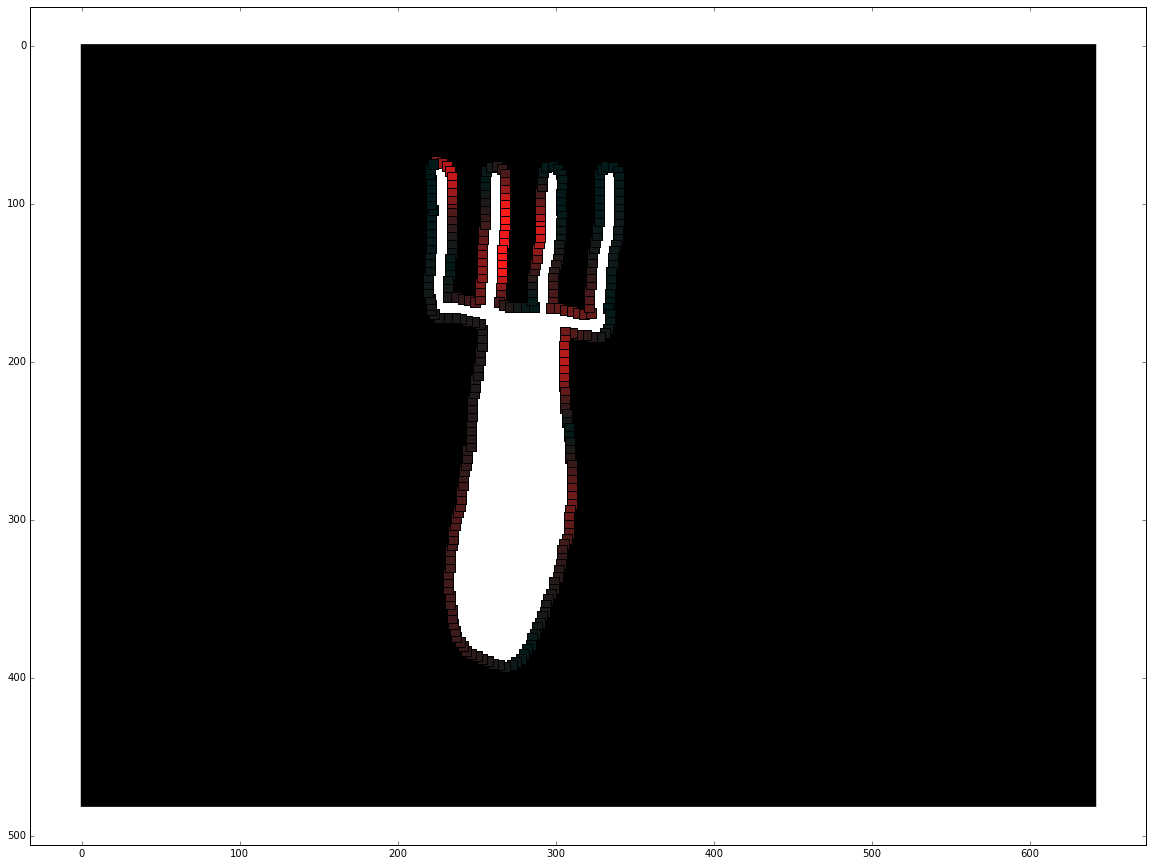

In [107]:
elephant2 = preprocess_image_without_smooth(data_images[35])

el2_dense_border = trace_border(elephant2)

el2_border = [el2_dense_border[i] for i in range(len(el2_dense_border)) if i%5 == 0]

x_el2 = np.array([x for (x,y) in el2_border])
y_el2 = np.array([y for (x,y) in el2_border])
curvs_el2 = curvature_splines(x_el2, y_el2)

norm_el2_curv = normalize(curvs_el2, norm='max')
pos_el2_curv = []
for x in norm_car_curv[0]:
    if x>=0:
        pos_el2_curv.append(x)
    elif x<-1:
        pos_el2_curv.append(1)
    else:
        pos_el2_curv.append(-x)

colors_el2 = [(curv, 0.1, 0.1) for curv in pos_el2_curv]


width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(elephant2, cmap=plt.cm.gray)

ax.scatter([b[1] for b in el2_border], [b[0] for b in el2_border], c=colors_el2, s=100, marker=',')

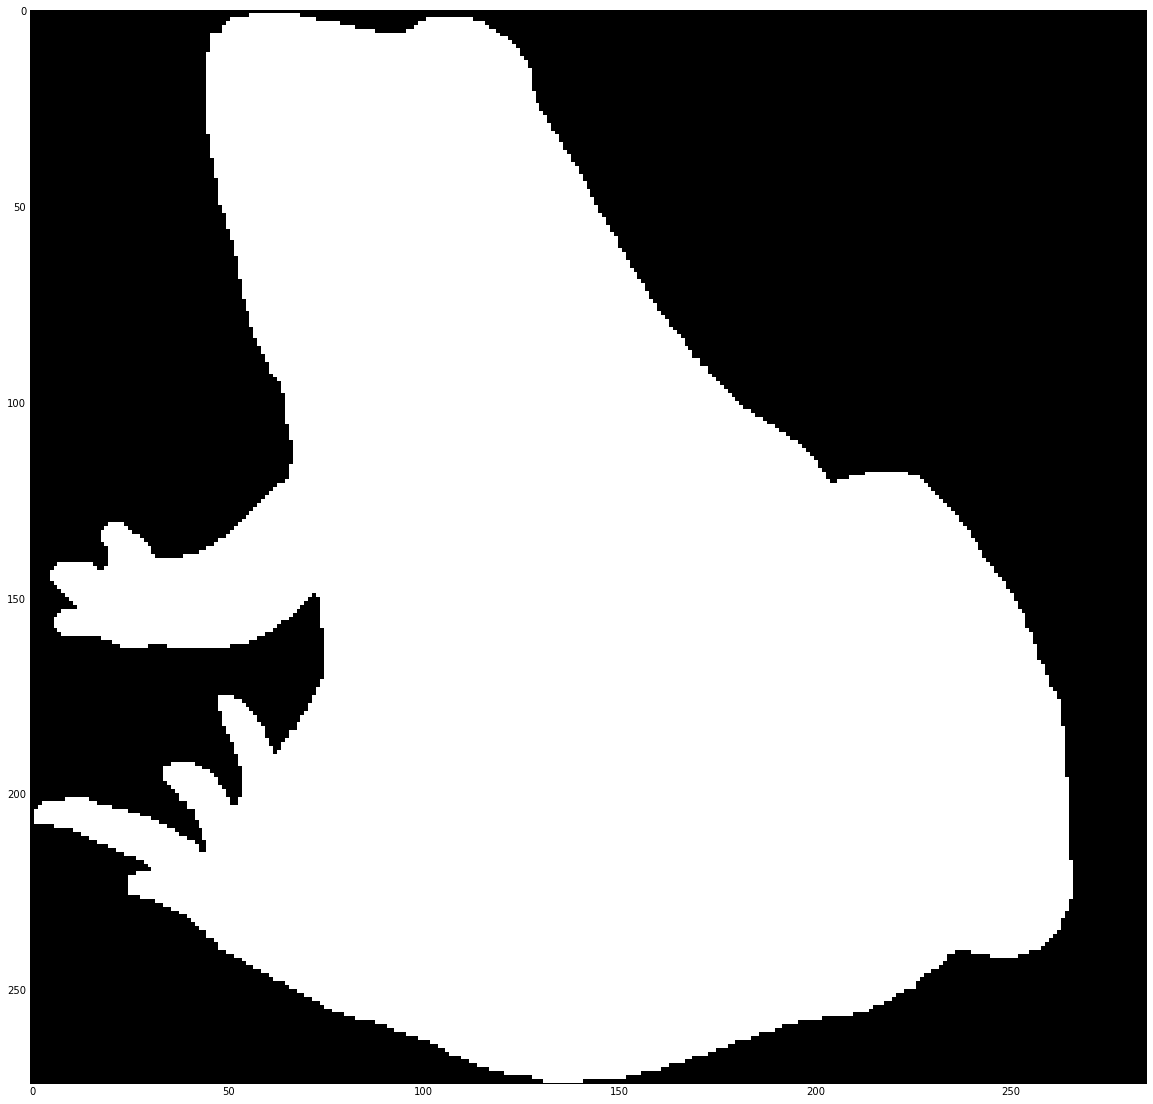

In [100]:
imshow(data_images[32])

In [456]:
new_im = preprocess_image(data_images[0])
new_im[new_im > 0] = 1 

In [457]:
per = perimeter(new_im)

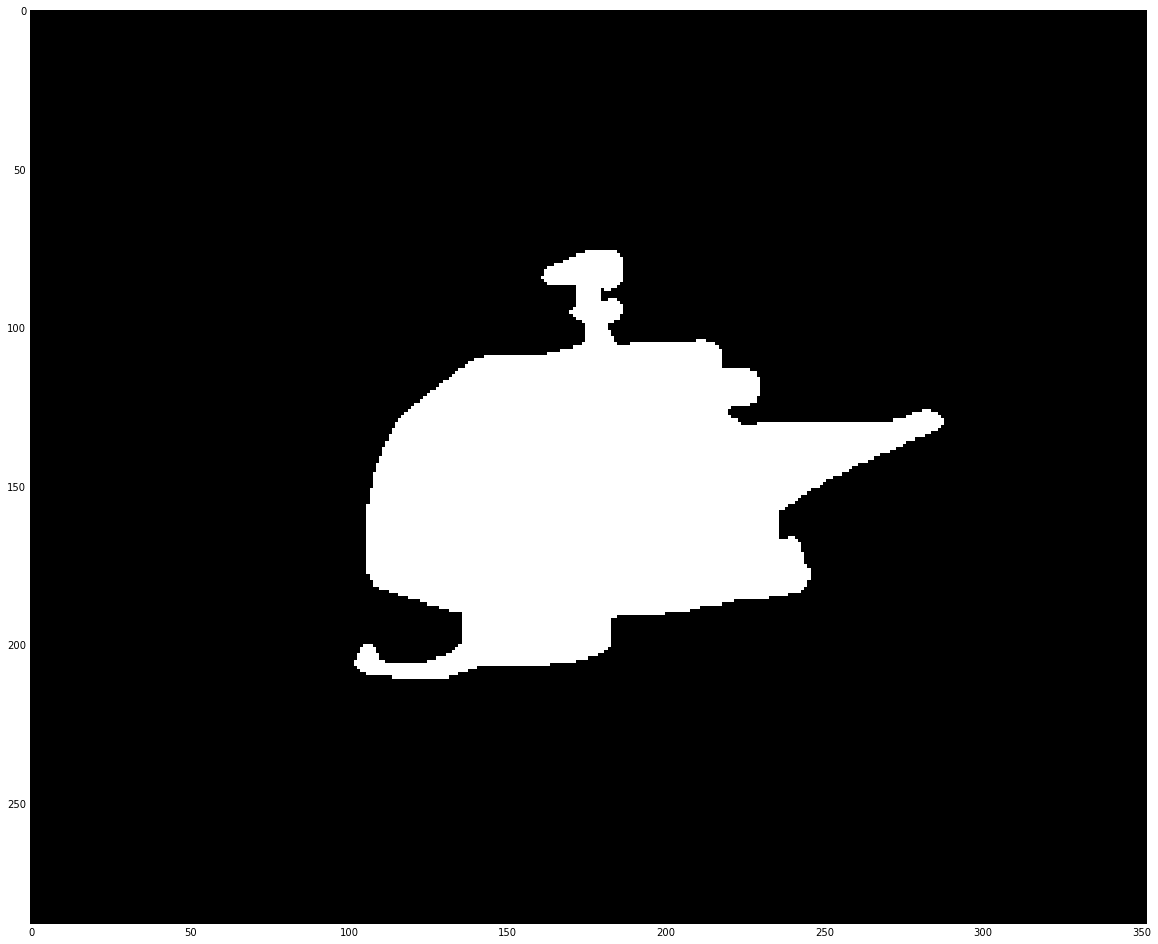

In [505]:
bad_guy = data_images[25]
imshow(bad_guy)

In [480]:
from skimage.measure import regionprops
from skimage.measure import label

In [513]:
new_im = preprocess_image(bad_guy)
lbs = label(new_im)
properties = regionprops(lbs)

In [512]:
sum(new_im == 0)

90646

In [514]:
x = (properties[0].bbox[2] - properties[0].bbox[0]) / 2.
y = (properties[0].bbox[3] - properties[0].bbox[1]) / 2.

In [515]:
properties[0].centroid

(152.20625936407527, 178.1746295988014)

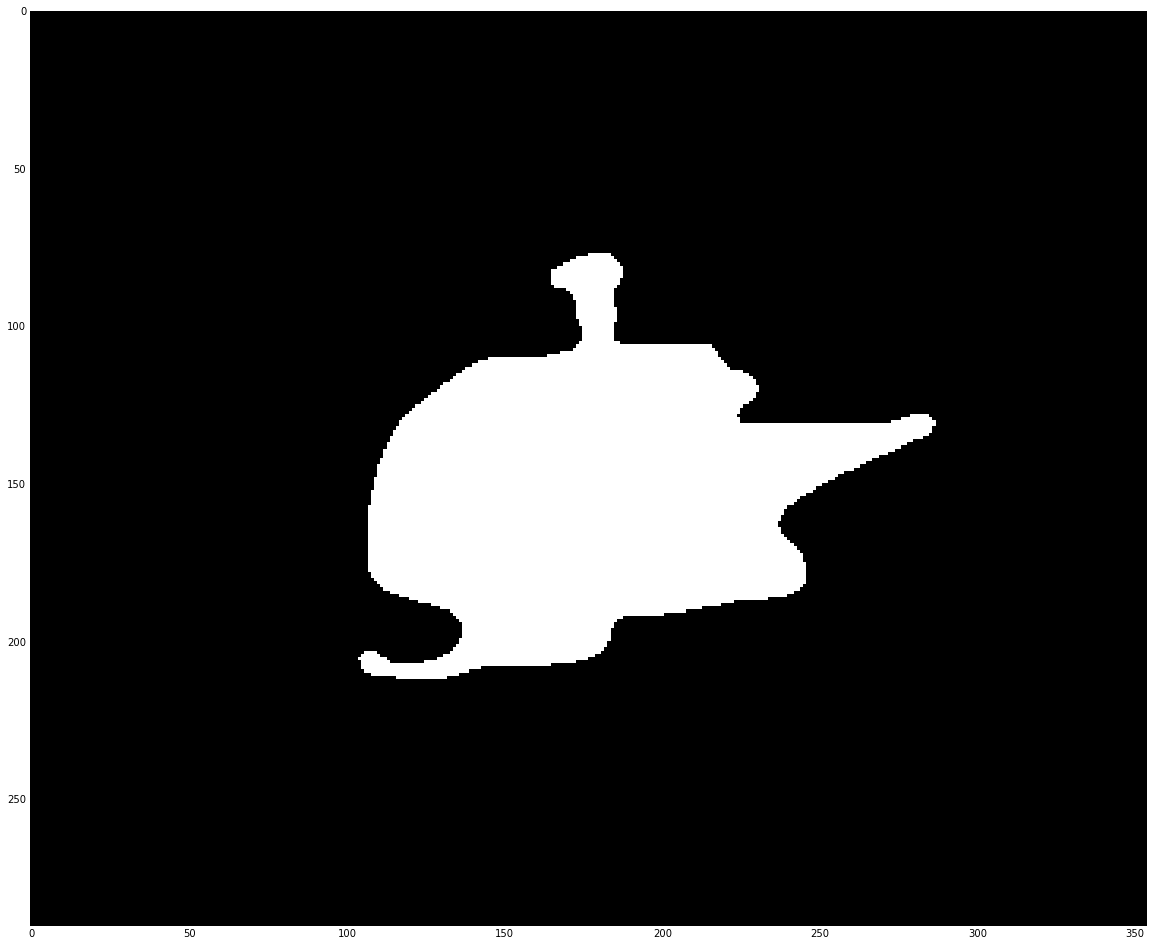

In [516]:
imshow(new_im)

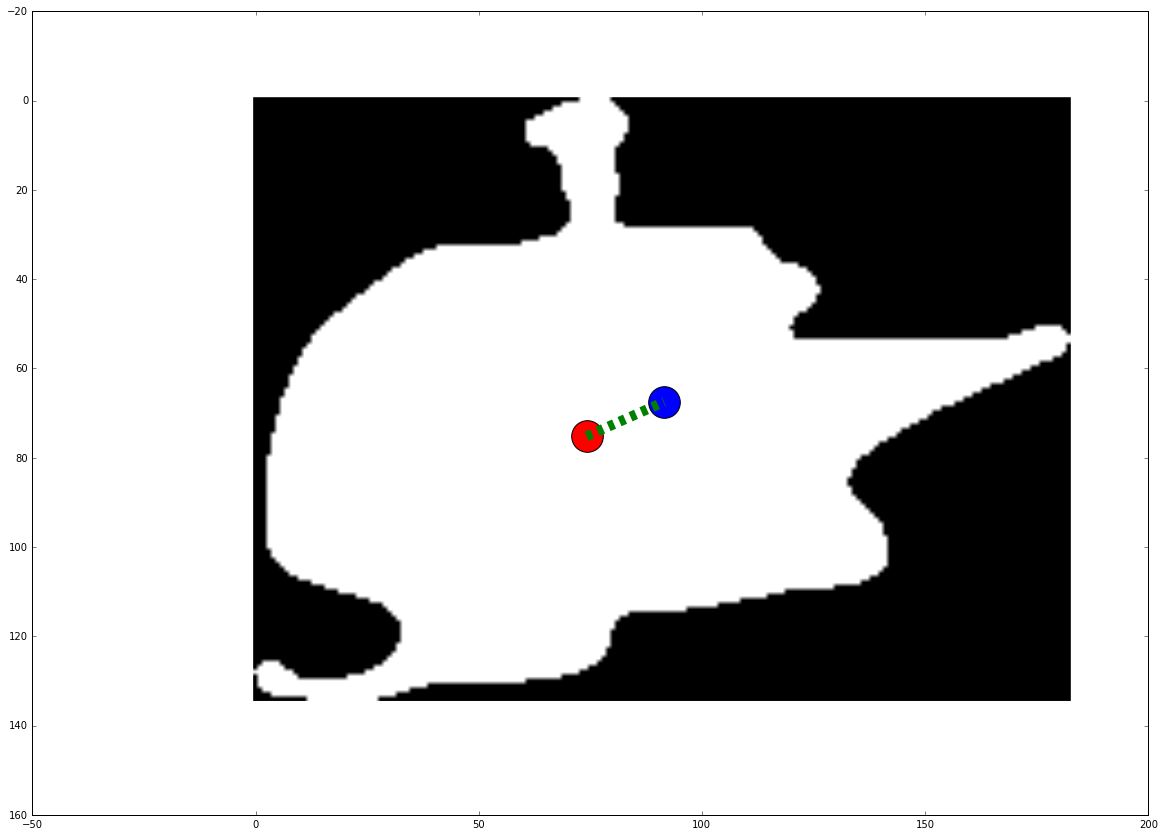

In [517]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.imshow(properties[0].image, cmap=plt.cm.gray)
ax1.scatter([properties[0].local_centroid[1]], [properties[0].local_centroid[0]],  marker='o', c='r', s=1000)
ax1.scatter([y], [x], marker='o', c='b', s=1000)
ax1.plot([properties[0].local_centroid[1], y], [properties[0].local_centroid[0], x], 'g--', linewidth=10.0)


In [518]:
def centriod_displacement(image):
    img_labels = label(im)
    binary = im
    binary[binary > 0] = 1
    lbs = label(binary)
    
    properties = regionprops(lbs)
    
    box = properties[0].bbox
    
    height = abs(box[2] - box[0])
    width = abs(box[3] - box[1])
    
    centroid = np.array([properties[0].local_centroid[0],
                properties[0].local_centroid[1]])
    
    scaled_centriod = np.array([centroid[0] / height, centroid[1] / width])
    
    scaled_dist = numpy.linalg.norm(np.array([0.5, 0.5]) - scaled_centriod)
    return scaled_dist

In [523]:
centriod_displacement(new_im)

0.041206013875689361

In [524]:
original = properties[0].image*1.
lr = np.fliplr(original)
ud = np.flipud(original)

In [525]:
np.inf

inf

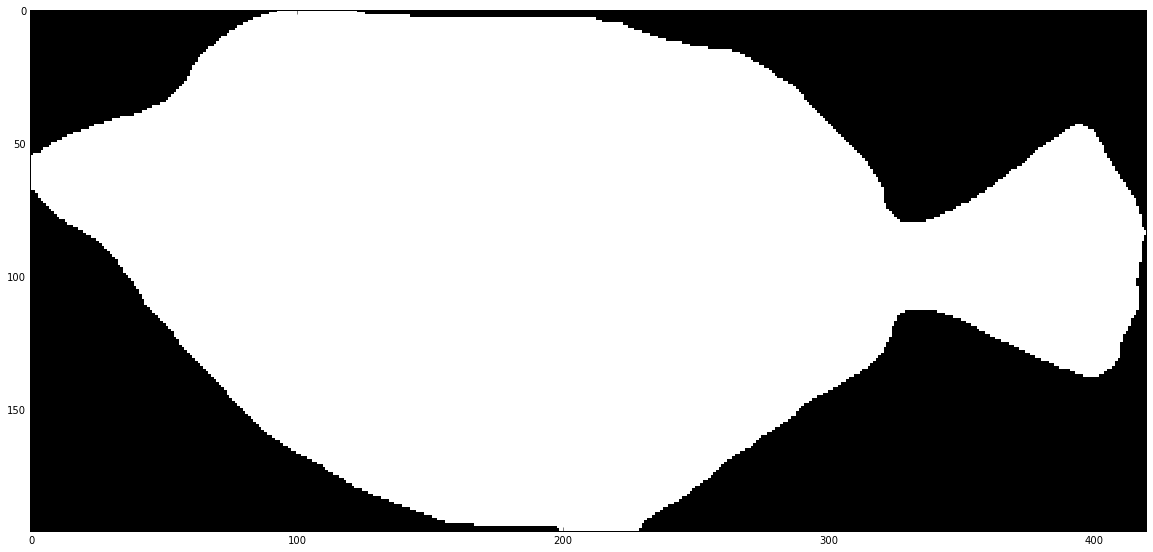

In [526]:
imshow(r45)

In [492]:
original

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [493]:
np.linalg.norm(original - ud, ord=-inf)

0.0

In [494]:
from scipy.spatial.distance import matching, correlation

In [527]:
(properties[0].image.flatten()+ud.flatten())

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [528]:
(min(abs(properties[0].image.flatten()-ud.flatten())/(properties[0].image.flatten()+ud.flatten())))

-c:1: RuntimeWarning: invalid value encountered in true_divide


nan

In [529]:
lr.flatten()

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [498]:
from skimage.morphology import octagon
from skimage.feature import (corner_fast, corner_peaks,
                             corner_orientations)
corners = corner_peaks(corner_fast(original, 9), min_distance=1)

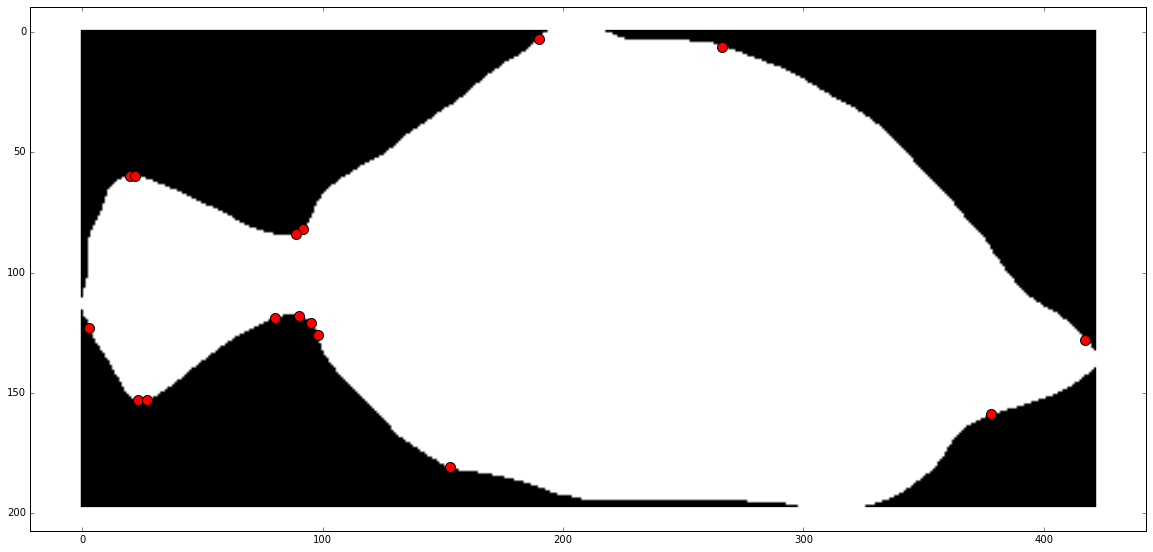

In [499]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.imshow(original, cmap=plt.cm.gray)
ax1.scatter([c[1] for c in corners], [c[0] for c in corners],  marker='o', c='r', s=100)

In [530]:
properties[0].moments_hu.shape

(7,)